# RNN cross validation
Classify pc vs nc RNA.

Set aside the 20% test set, stratified by length.
On the remaining 80%,
perform 5-fold cross validation.

Use K=3. 
Use RNN(16,16,16,1).

To do: 
Masking the Ns.
Either bidirectional RNN or try starting with the Ns.
Handle end case of max len < num K-mers.
K-mer embedding (like word2vec).

Here, repeat RNN_06 which ran on 1K-2K.
Try other subsets (constrained by issue of padding to full length).

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import OneHotEncoder

# For the manual cross validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold

tf.keras.backend.set_floatx('float32')

EPOCHS=5
SPLITS=2
K=3


In [2]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
def make_train_test(data):
    bin_labels= sizebin(data)
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    # split(x,y) expects that y is the labels. 
    # Trick: Instead of y, give it it the bin labels that we generated.
    for train_index,test_index in splitter.split(data,bin_labels):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
    return (train_set,test_set)

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)

def subset(data_set,min_len,max_len):
    print("original "+str(data_set.shape))
    too_short = data_set[ data_set['seqlen'] < min_len ].index
    no_short=data_set.drop(too_short)
    print("no short "+str(no_short.shape))
    too_long = no_short[ no_short['seqlen'] >= max_len ].index
    no_long_no_short=no_short.drop(too_long)
    print("no long, no short "+str(no_long_no_short.shape))
    return no_long_no_short


In [3]:
def do_cross_validation(X,y,K,maxlen,eps):
    cv_scores = []
    act="sigmoid"
    dt='float32'
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.2, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]
        print("BUILD MODEL")
        seq_len=maxlen  # None indicates variable length
        input_features=4**K+1   # 64 DNA K-mers at K=3
        rnn2 = keras.models.Sequential([
            keras.layers.SimpleRNN(16, return_sequences=True, 
                                   input_shape=[seq_len,input_features]),
            keras.layers.SimpleRNN(16, return_sequences=True),
            keras.layers.SimpleRNN(16, return_sequences=True),
            keras.layers.SimpleRNN(1),
        ])

        bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
        print("COMPILE")
        rnn2.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
        print("FIT")
        history=rnn2.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        fold += 1
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = rnn2.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (rnn2.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


In [4]:
def generate_encoding_set(K,uniform_len):
    all_possible=['A','C','G','T']
    if K==2:
        all_possible=['AA','AC','AG','AT','CA','CC','CG','CT','GA','GC','GG','GT','TA','TC','TG','TT']
    else:
        k=1
        while k<K:
            temp=[]
            for kmer in all_possible:
                temp.append(kmer+'A')
                temp.append(kmer+'C')
                temp.append(kmer+'G')
                temp.append(kmer+'T')
            k += 1
            all_possible=temp
    i=16
    pad_kmer='N'*K
    while i < uniform_len:
        all_possible.append(pad_kmer)
        i += 1
    return all_possible

def generate_all_kmers(K):
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    return shorter_kmers

def train_encoder(kmers):
    narray = np.array(kmers)
    array2d = narray.reshape(-1, 1)
    encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoder.fit(array2d)
    return encoder


In [5]:
def strings_to_kmers(data,K,uniform_len):
    all_seqs=[]
    pad_char='N'
    pad_kmer=pad_char*K
    # pad_kmer=None      # Prefer this to the above. Will it work? No. Encoder balks.
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1:
            kmer=seq[i:i+K]
            kmers.append(kmer)
            i += 1
        while i < uniform_len:
            kmers.append(pad_kmer)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

## Load and partition sequences

In [6]:
nc_seq=load_fasta('ncRNA.fasta',0)
pc_seq=load_fasta('pcRNA.fasta',1)
all_seq=pd.concat((nc_seq,pc_seq),axis=0)

(train_set,test_set)=make_train_test(all_seq)
(X_test,y_test)=separate_X_and_y(test_set)

nc_seq=None
pc_seq=None
all_seq=None

In [7]:
def run_all(MINLEN,MAXLEN,train_set):
    # Extract subset by length
    print("Subset %d - %d"%(MINLEN,MAXLEN))
    train_set=subset(train_set,MINLEN,MAXLEN)# One array to two: X and y
    (X_train_all,y_train_all)=separate_X_and_y(train_set)

    # The returned values are Pandas dataframes.
    # print(X_train_all.shape,y_train_all.shape)
    # (X_train_all,y_train_all)
    # y: Pandas dataframe to Python list.
    # y_train_all=y_train_all.values.tolist()
    # The sequences lengths are bounded but not uniform.
    X_train_all
    print(type(X_train_all))
    print(X_train_all.shape)
    print(X_train_all.iloc[0])
    print(len(X_train_all.iloc[0]['sequence']))

    # X: List of string to List of uniform-length ordered lists of K-mers.
    X_train_kmers=strings_to_kmers(X_train_all,K,MAXLEN)
    # X: true 2D array (no more lists)
    X_train_kmers.shape
    encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
    # This takes a long time and may not be complete.
    # We should fit to sequences that absolutely contain every possible K-mer.
    sample_data=generate_encoding_set(K,MAXLEN)
    sample=np.array(sample_data).reshape(-1, 1)
    print("fit...")
    encoder.fit(sample)
    print(str(encoder.categories_))

    print("transform...")
    # From pandas dataframe to numpy to list to numpy
    print(type(X_train_kmers))
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        X1=encoder.transform(kmer_sequence.to_numpy().reshape(-1, 1))
        tmp_seqs.append(X1)
    encoded_seqs=np.array(tmp_seqs)
    tmp_seqs=None
    X_train_kmers=None
    print(type(encoded_seqs))
    print(encoded_seqs.shape)
    #X_train_encoded=encoder.transform(X_train_kmers.to_numpy().reshape(-1, 1))  # FLATTENS
    #X_train_encoded  # LONG TIME!

    labels=y_train_all.to_numpy()
    do_cross_validation(encoded_seqs,labels,K,MAXLEN,EPOCHS)

## Len 200-1Kb


Subset 200 - 1000
original (30290, 4)
no short (30290, 4)
no long, no short (8879, 4)
<class 'pandas.core.frame.DataFrame'>
(8879, 1)
sequence    AGTCCCTCCCCAGCCCAGCAGTCCCTCCAGGCTACATCCAGGAGAC...
Name: 1280, dtype: object
348
fit...
[array(['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA',
       'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT', 'CAA', 'CAC',
       'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG',
       'CGT', 'CTA', 'CTC', 'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT',
       'GCA', 'GCC', 'GCG', 'GCT', 'GGA', 'GGC', 'GGG', 'GGT', 'GTA',
       'GTC', 'GTG', 'GTT', 'NNN', 'TAA', 'TAC', 'TAG', 'TAT', 'TCA',
       'TCC', 'TCG', 'TCT', 'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC',
       'TTG', 'TTT'], dtype='<U3')]
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(8879, 1000, 65)
BUILD MODEL
COMPILE
FIT
Epoch 1/5
222/222 [==============================] - 172s 776ms/step - loss: 0.7214 - accuracy: 0.5056 - val_loss: 0.6940 - 

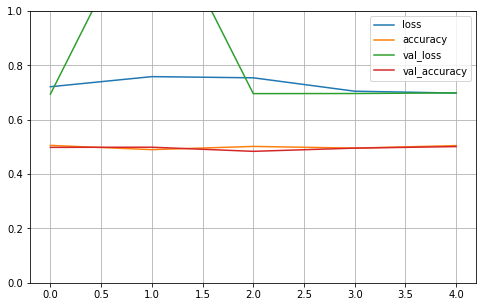

accuracy: 50.11%
BUILD MODEL
COMPILE
FIT
Epoch 1/5
222/222 [==============================] - 179s 807ms/step - loss: 0.7060 - accuracy: 0.5056 - val_loss: 0.6931 - val_accuracy: 0.4989
Epoch 2/5
222/222 [==============================] - 163s 735ms/step - loss: 0.6943 - accuracy: 0.4988 - val_loss: 0.6930 - val_accuracy: 0.5034
Epoch 3/5
222/222 [==============================] - 160s 720ms/step - loss: 0.6947 - accuracy: 0.5082 - val_loss: 0.6947 - val_accuracy: 0.4994
Epoch 4/5
222/222 [==============================] - 163s 734ms/step - loss: 0.6939 - accuracy: 0.4971 - val_loss: 0.6983 - val_accuracy: 0.4983
Epoch 5/5
222/222 [==============================] - 161s 723ms/step - loss: 0.6938 - accuracy: 0.5015 - val_loss: 0.6937 - val_accuracy: 0.5017
Fold 2, 5 epochs


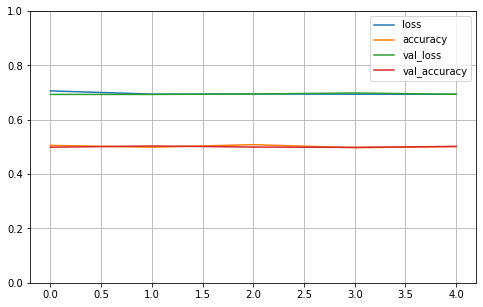

accuracy: 50.17%

Validation core mean 50.14% (+/- 0.03%)


In [8]:
MINLEN=200
MAXLEN=1000
run_all(MINLEN,MAXLEN,train_set)

## Len 1K-2Kb

Subset 1000 - 2000
original (30290, 4)
no short (9273, 4)
no long, no short (3368, 4)
<class 'pandas.core.frame.DataFrame'>
(3368, 1)
sequence    GGCGGGGTCGACTGACGGTAACGGGGCAGAGAGGCTGTTCGCAGAG...
Name: 12641, dtype: object
1338
fit...
[array(['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA',
       'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT', 'CAA', 'CAC',
       'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG',
       'CGT', 'CTA', 'CTC', 'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT',
       'GCA', 'GCC', 'GCG', 'GCT', 'GGA', 'GGC', 'GGG', 'GGT', 'GTA',
       'GTC', 'GTG', 'GTT', 'NNN', 'TAA', 'TAC', 'TAG', 'TAT', 'TCA',
       'TCC', 'TCG', 'TCT', 'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC',
       'TTG', 'TTT'], dtype='<U3')]
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(3368, 2000, 65)
BUILD MODEL
COMPILE
FIT
Epoch 1/5
85/85 [==============================] - 186s 2s/step - loss: 0.7104 - accuracy: 0.6158 - val_loss: 0.7039 - val

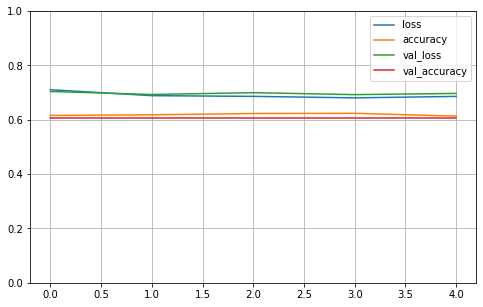

accuracy: 60.53%
BUILD MODEL
COMPILE
FIT
Epoch 1/5
85/85 [==============================] - 176s 2s/step - loss: 9.5103 - accuracy: 0.3834 - val_loss: 9.6578 - val_accuracy: 0.3739
Epoch 2/5
85/85 [==============================] - 163s 2s/step - loss: 9.5103 - accuracy: 0.3834 - val_loss: 9.6578 - val_accuracy: 0.3739
Epoch 3/5
85/85 [==============================] - 163s 2s/step - loss: 9.5103 - accuracy: 0.3834 - val_loss: 9.6578 - val_accuracy: 0.3739
Epoch 4/5
85/85 [==============================] - 164s 2s/step - loss: 9.5103 - accuracy: 0.3834 - val_loss: 9.6578 - val_accuracy: 0.3739
Epoch 5/5
85/85 [==============================] - 167s 2s/step - loss: 9.5103 - accuracy: 0.3834 - val_loss: 9.6578 - val_accuracy: 0.3739
Fold 2, 5 epochs


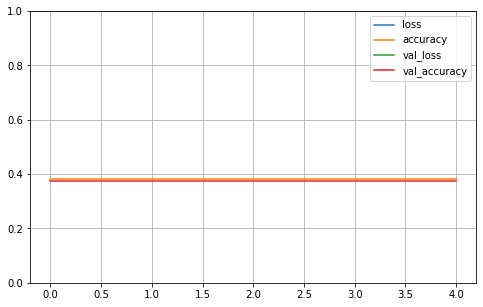

accuracy: 37.39%

Validation core mean 48.96% (+/- 11.57%)


In [9]:
MINLEN=1000
MAXLEN=2000
run_all(MINLEN,MAXLEN,train_set)

## Len 2K-3Kb

Subset 2000 - 3000
original (30290, 4)
no short (3221, 4)
no long, no short (1351, 4)
<class 'pandas.core.frame.DataFrame'>
(1351, 1)
sequence    GTCATTCTAGCTGCCTGCTGCCTCCGCAGCGTCCCCCCAGCTCTCC...
Name: 19713, dtype: object
2039
fit...
[array(['AAA', 'AAC', 'AAG', 'AAT', 'ACA', 'ACC', 'ACG', 'ACT', 'AGA',
       'AGC', 'AGG', 'AGT', 'ATA', 'ATC', 'ATG', 'ATT', 'CAA', 'CAC',
       'CAG', 'CAT', 'CCA', 'CCC', 'CCG', 'CCT', 'CGA', 'CGC', 'CGG',
       'CGT', 'CTA', 'CTC', 'CTG', 'CTT', 'GAA', 'GAC', 'GAG', 'GAT',
       'GCA', 'GCC', 'GCG', 'GCT', 'GGA', 'GGC', 'GGG', 'GGT', 'GTA',
       'GTC', 'GTG', 'GTT', 'NNN', 'TAA', 'TAC', 'TAG', 'TAT', 'TCA',
       'TCC', 'TCG', 'TCT', 'TGA', 'TGC', 'TGG', 'TGT', 'TTA', 'TTC',
       'TTG', 'TTT'], dtype='<U3')]
transform...
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(1351, 3000, 65)
BUILD MODEL
COMPILE
FIT
Epoch 1/5
34/34 [==============================] - 141s 4s/step - loss: 8.8509 - accuracy: 0.3398 - val_loss: 6.2224 - val

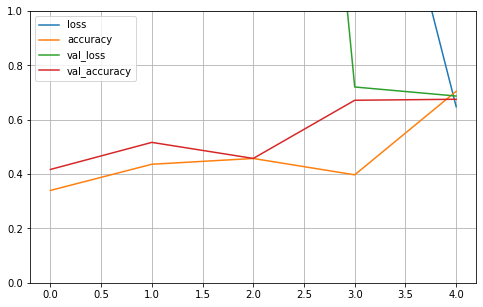

accuracy: 67.53%
BUILD MODEL
COMPILE
FIT
Epoch 1/5
34/34 [==============================] - 148s 4s/step - loss: 9.9658 - accuracy: 0.3241 - val_loss: 10.9352 - val_accuracy: 0.2878
Epoch 2/5
34/34 [==============================] - 134s 4s/step - loss: 4.2386 - accuracy: 0.5463 - val_loss: 0.6542 - val_accuracy: 0.7122
Epoch 3/5
34/34 [==============================] - 133s 4s/step - loss: 0.6216 - accuracy: 0.7000 - val_loss: 0.6019 - val_accuracy: 0.7122
Epoch 4/5
34/34 [==============================] - 132s 4s/step - loss: 0.6117 - accuracy: 0.7000 - val_loss: 0.6014 - val_accuracy: 0.7122
Epoch 5/5
34/34 [==============================] - 138s 4s/step - loss: 0.6120 - accuracy: 0.7000 - val_loss: 0.6032 - val_accuracy: 0.7122
Fold 2, 5 epochs


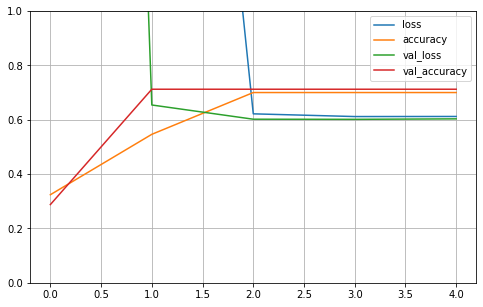

accuracy: 71.22%

Validation core mean 69.37% (+/- 1.85%)


In [10]:
MINLEN=2000
MAXLEN=3000
run_all(MINLEN,MAXLEN,train_set)